In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
plt.style.use('seaborn-pastel')
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 16})
sns.set_theme(style="white")


def angle2binNum(angles):
    alignedD_360 = [a % 360 for a in angles]
    anglebinNum = [round(a/30)+1 for a in alignedD_360]
    anglebinNum = [1 if binN == 13 else binN for binN in anglebinNum]

    # Compute pie slices
    N = int(360/30)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    binsAngleNum = []
    for binNum in range(1,13):
        binAngleNum = 0
        for a in anglebinNum:
            if a == binNum:
                binAngleNum +=1
        binsAngleNum.append(binAngleNum)
    return binsAngleNum


def plotAngleRadar(angles):
    binsAngleNum = angle2binNum(angles)
    N = int(360/30)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    width = 2*np.pi / (N+1)
    ax = plt.subplot(projection='polar')
    ax.bar(theta, binsAngleNum,width=width,bottom=0.0, alpha=0.5)
    ax.set_yticks([0,500,1000,1500])
    plt.show()


def plot_angle_acc(corr_angles,error_angles):
    import math
    binsAngle_corrNum = np.array(angle2binNum(corr_angles))
    binsAngle_errorNum = np.array(angle2binNum(error_angles))
    binsAngle_acc = binsAngle_corrNum/(binsAngle_corrNum+binsAngle_errorNum)

    N = int(360/30)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    width = 2*np.pi / (N+1)
    ax = plt.subplot(projection='polar')
    binsAngle_acc = binsAngle_acc - 0.5
    ax.bar(theta, binsAngle_acc, width=width, bottom=0.0, alpha=0.5)
    ax.set_yticks([0,0.2,0.4])
    ax.set_yticklabels([0.5,0.7,0.9])
    plt.show()


<ipython-input-1-b1fedb6cdc33>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [4]:
# example for trial sample
pid = ['sub-180']
run_template = r'/mnt/workdir/DCM/BIDS/derivatives/Events/game1/hexagon_spat/{}/6fold/{}_task-game1_run-{}_events.tsv'
trials_angle = []
for sub_id in pid:
    for run_id in range(1,7):
        run_path = run_template.format(sub_id,sub_id,run_id)
        run_file = pd.read_csv(run_path,sep='\t')
        run_angles = run_file.query('trial_type=="M2"')['angle'].to_list()
        trials_angle.extend(run_angles)
plotAngleRadar(trials_angle)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workdir/DCM/BIDS/derivatives/Events/game1/hexagon_spat/sub-180/6fold/sub-180_task-game1_run-1_events.tsv'

In [ ]:
"""
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
pid = data['Participant_ID'].to_list()
pid = ['sub-196','sub-196']

run_template = r'/mnt/workdir/DCM/BIDS/derivatives/Events/game1/cv_train1/{}/6fold/{}_task-game1_run-{}_events.tsv'
odd_trials_angle = []
even_trials_angle = []
for sub_id in pid:
    for run_id in range(1,7):
        run_path = run_template.format(sub_id,sub_id,run_id)
        run_file = pd.read_csv(run_path,sep='\t')
        run_odd = run_file.query('trial_type=="M2_corr_odd"')['angle'].to_list()
        run_even = run_file.query('trial_type=="M2_corr_even"')['angle'].to_list()
        odd_trials_angle.extend(run_odd)
        even_trials_angle.extend(run_even)
plotAngleRadar(odd_trials_angle)
plotAngleRadar(even_trials_angle)
"""

In [5]:
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
pid = data['Participant_ID'].to_list()

#  calculate the angle
run_template = r'/mnt/workdir/DCM/BIDS/derivatives/Events/game1/distance_spct/{}/6fold/{}_task-game1_run-{}_events.tsv'
corr_trials_angle = []
error_trials_angle = []
acc_trials_angle = []
for sub_id in pid:
    for run_id in range(1,7):
        run_path = run_template.format(sub_id,sub_id,run_id)
        run_file = pd.read_csv(run_path,sep='\t')
        run_corr = run_file.query('trial_type=="M2_corr"')['angle'].to_list()
        run_error = run_file.query('trial_type=="M2_error"')['angle'].to_list()
        corr_trials_angle.extend(run_corr)
        error_trials_angle.extend(run_error)

plotAngleRadar(corr_trials_angle)
plotAngleRadar(error_trials_angle)
plot_angle_acc(corr_trials_angle,error_trials_angle)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workdir/DCM/BIDS/derivatives/Events/game1/distance_spct/sub-010/6fold/sub-010_task-game1_run-1_events.tsv'

# Check the bais of the stalemate trials

In [59]:
# get the angle distribution of stalemate trials
import os
import numpy as np
import pandas as pd
from analysis.mri.event.base import GAME1EV


class GAME1EV_tmp(GAME1EV):
    def __init__(self, behDataPath):
        GAME1EV.__init__(self, behDataPath)

    def label_trial(self):
        self.behData = self.behData.fillna('None')
        if self.dformat == 'trial_by_trial':
            keyResp_list = self.behData['resp.keys']
        elif self.dformat == 'summary':
            keyResp_tmp = self.behData['resp.keys_raw']
            keyResp_list = []
            for k in keyResp_tmp:
                if k == 'None':
                    keyResp_list.append(k)
                else:
                    keyResp_list.append(k[1])
        else:
            raise Exception("You need specify behavioral data format.")

        angle = self.behData['angles']
        trial_corr = []
        fr = []
        fresult = []
        for keyResp, row in zip(keyResp_list, self.behData.itertuples()):
            rule = row.fightRule
            fr.append(rule)
            if rule == '1A2D':
                fight_result = row.pic1_ap - row.pic2_dp
                if fight_result > 0:
                    correctAns = 1
                elif fight_result <0:
                    correctAns = 2
                elif fight_result == 0:
                    correctAns = -1
                else:
                    raise Exception("fight result is not a number.")
            elif rule == '1D2A':
                fight_result = row.pic2_ap - row.pic1_dp
                if fight_result > 0:
                    correctAns = 2
                elif fight_result <0:
                    correctAns = 1
                elif fight_result == 0:
                    correctAns = -1
                else:
                    raise Exception("fight result is not a number.")
            else:
                raise Exception("None of rule have been found in the file.")
            fresult.append(fight_result)
        pic1_ap = self.behData['pic1_ap']
        pic2_ap = self.behData['pic2_ap']
        pic1_dp = self.behData['pic1_dp']
        pic2_dp = self.behData['pic2_dp']
        distance = np.sqrt(self.behData['ap_diff'] ** 2 + self.behData['dp_diff'] ** 2)
        trials_info = pd.DataFrame({'pic1_ap':pic1_ap,'pic2_ap':pic2_ap,'pic1_dp':pic1_dp,'pic2_dp':pic2_dp,
                                    'fightRule':fr,'fightResult':fresult,'angle':angle,'distance':distance})
        return trials_info

task = 'game1'
if task == 'game1':
    runs = range(1, 7)
    behav_template = '/mnt/workdir/DCM/sourcedata/sub_{}/Behaviour/' \
                             'fmri_task-game1/sub-{}_task-{}_run-{}.csv'
elif task == 'game2':
    runs = range(1, 3)
    behav_template = '/mnt/workdir/DCM/sourcedata/sub_{}/Behaviour/' \
                             'fmri_task-game2-test/sub-{}_task-{}_run-{}.csv'
else:
    raise Exception("You need specify a correct task name.")

participants_data = pd.read_csv('/mnt/workdir/DCM/BIDS/participants.tsv', sep='\t')
subjects = participants_data.query(f'{task}_fmri>=0.5')['Participant_ID'].str.split('-').str[-1].str.zfill(3)

df = pd.DataFrame()
for subj in subjects:
    print(f'----sub-{subj}----')
    for idx in runs:
        run_id = str(idx)
        behav_path = behav_template.format(subj, subj, task, run_id)
        game1ev = GAME1EV_tmp(behav_path)
        trials_info = game1ev.label_trial()
        trials_info['sub_id'] = subj
        df = df.append(trials_info,ignore_index=True)
df.to_csv('/mnt/workdir/DCM/Result/validation_trial_bias/stalemate.csv',index=False)

----sub-010----
----sub-011----
----sub-012----
----sub-015----
----sub-016----
----sub-017----
----sub-018----
----sub-022----
----sub-023----
----sub-024----
----sub-025----
----sub-029----
----sub-031----
----sub-032----
----sub-036----
----sub-037----
----sub-043----
----sub-046----
----sub-049----
----sub-050----
----sub-053----
----sub-055----
----sub-059----
----sub-060----
----sub-061----
----sub-062----
----sub-063----
----sub-064----
----sub-065----
----sub-067----
----sub-068----
----sub-069----
----sub-070----
----sub-071----
----sub-072----
----sub-073----
----sub-074----
----sub-075----
----sub-076----
----sub-077----
----sub-078----
----sub-079----
----sub-080----
----sub-082----
----sub-084----
----sub-085----
----sub-086----
----sub-088----
----sub-089----
----sub-090----
----sub-091----
----sub-092----
----sub-093----
----sub-094----
----sub-095----
----sub-096----
----sub-097----
----sub-098----
----sub-099----
----sub-100----
----sub-101----
----sub-102----
----sub-

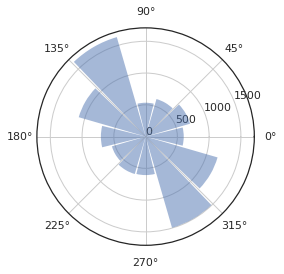

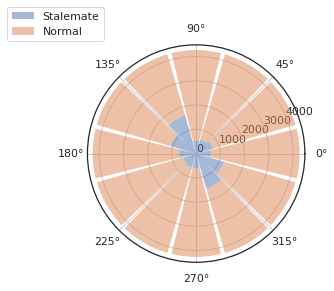

In [3]:
# plot the angle distribution of stalemate trials
df = pd.read_csv('/mnt/workdir/DCM/Result/validation_trial_bias/stalemate.csv')
df_stalemate = df[df['fightResult']==0]
df_normal =  df[df['fightResult']!=0]
angles_normal = df_normal['angle'].to_list()
angles_stalemate = df_stalemate['angle'].to_list()

# plot the distribution of the stalemate trials
binsAngleNum = angle2binNum(angles_stalemate)
N = int(360/30)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
width = 2*np.pi / (N+1)
ax = plt.subplot(projection='polar')
ax.bar(theta, binsAngleNum,width=width,bottom=0.0, alpha=0.5,linewidth=0)
ax.set_yticks([0,500,1000,1500])
plt.savefig('/mnt/workdir/DCM/Result/validation_trial_bias/stalemate_angle_distribution.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

# plot the distribution of the stalemate trials and normal trials
ax = plt.subplot(projection='polar')
binsAngleNum_normal = angle2binNum(angles_normal)
binsAngleNum_stalemate = angle2binNum(angles_stalemate)
angle_nub_count = {'Stalemate':binsAngleNum_stalemate,'Normal':binsAngleNum_normal}

bottom = np.zeros(12)
for trial_type, num_count in angle_nub_count.items():
    p = ax.bar(theta, num_count,width=width,label=trial_type,bottom=bottom, alpha=0.5,linewidth=0)
    bottom += num_count

ax.legend(loc="upper right", bbox_to_anchor=(0.1, 1.2))
ax.set_yticks([0,1000,2000,3000,4000])
plt.savefig('/mnt/workdir/DCM/Result/validation_trial_bias/angle_distribution_stalemate&normal.pdf',dpi=300,bbox_inches='tight',pad_inches=0,transparent=True)
plt.savefig('/mnt/workdir/DCM/Result/validation_trial_bias/angle_distribution_stalemate&normal.svg',dpi=300,bbox_inches='tight',pad_inches=0,transparent=True)
plt.show()

In [116]:
#  Check the label_trial function is right
sm_num = 0
nm_num = 0
for index,row in df.iterrows():
    rule = row.fightRule
    if rule == '1A2D':
        fre = row.pic1_ap - row.pic2_dp
    elif rule == '1D2A':
        fre = row.pic2_ap - row.pic1_dp
    else:
        raise Exception("The rule is not right.")
    if fre == 0:
        sm_num+=1
    else:
        nm_num+=1
    if fre == row.fightResult:
        continue
    else:
        raise Exception("The fight result is not consistence!!!")
print("Normal trials:",nm_num)
print("Stalemate trials:",sm_num)

Normal trials: 40806
Stalemate trials: 10350


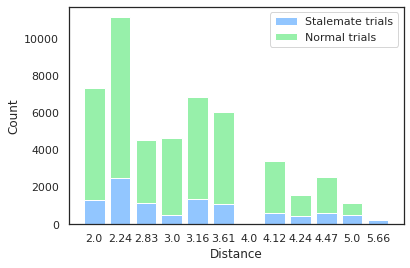

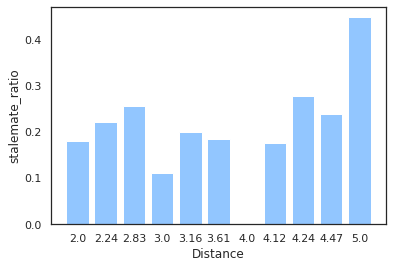

In [108]:
# plot the distance distribution of the stalemate trials
# get the count of distance for stalemate and normal trials
sm_distance_count = df_stalemate['distance'].value_counts().sort_index()
sm_distance_count.name = 'distance_stalemate'
nm_distance_count = df_normal['distance'].value_counts().sort_index()
nm_distance_count.name = 'distance_normal'

# merge the two count dataframes
distance_count = pd.merge(sm_distance_count, nm_distance_count, how='outer', left_index=True, right_index=True)

# convert the indices to string and set them as the x-ticks labels
x_ticks = [str(round(ix,2)) for ix in distance_count.index]

# plot the stacked bar chart
fig, ax = plt.subplots()
ax.bar(x_ticks, distance_count['distance_stalemate'], label='Stalemate trials')
ax.bar(x_ticks, distance_count['distance_normal'], bottom=distance_count['distance_stalemate'], label='Normal trials')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
ax.legend()
plt.savefig('/mnt/workdir/DCM/Result/validation_trial_bias/distance_distribution_stalemate&normal.svg',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

# plot ration
distance_count['stalemate_ratio'] = distance_count['distance_stalemate'] / (distance_count['distance_stalemate']+distance_count['distance_normal'])

fig, ax = plt.subplots()
ax.bar(x_ticks, distance_count['stalemate_ratio'], label='stalemate_ratio')
ax.set_xlabel('Distance')
ax.set_ylabel('stalemate_ratio')
plt.savefig('/mnt/workdir/DCM/Result/validation_trial_bias/distance_distribution_stalemate_ration.svg',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()